# Final pipe 2

## Import Libraries

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from catboost import CatBoostRegressor
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

In [61]:
import warnings
#from pandas.errors import FutureWarning

warnings.simplefilter(action='ignore', category=FutureWarning)

## Get data

In [2]:
df_train_init = pd.read_csv('LendingGame_Lender3/PastLoans.csv')
df_train_round_1 = pd.read_csv('LendingGame_Lender3/NewApplications_Lender3.csv')
df_result_round_1 = pd.read_csv('LendingGame_Lender3/31/Round1_Diagnostic_31.csv')

In [3]:
df_concat = (pd.concat([df_train_init,
                      (df_train_round_1
                       .drop(columns=['id'])
                       .assign(default = df_result_round_1.default))])
             .reset_index(drop=True))

In [4]:
df_concat.sample(10)

,sex,employment,married,income,digital1,digital2,digital3,default
132625,1,student,0,0,NaN,NaN,0.081342,0
132303,0,employed,0,6470,NaN,NaN,0.000000,0
76966,1,employed,0,15066,0.000000,0.633839,0.000000,0
174745,0,employed,1,49311,NaN,NaN,0.243748,0
36935,0,unemployed,0,0,0.000000,0.635200,0.000000,1
90163,0,employed,1,9742,0.598105,0.218271,0.000000,0
19797,1,retired,1,5505,0.000000,0.000000,0.146874,0
168054,1,student,0,0,NaN,NaN,0.659863,0
92977,1,employed,1,7534,0.744633,0.826177,0.000000,0
180258,0,employed,1,15354,NaN,NaN,0.000000,1


In [5]:
df_past = df_concat.copy()
df_past.income = df_past.income.astype('int32')
df_past.digital1 = df_past.digital1.astype('float32')
df_past.digital2 = df_past.digital2.astype('float32')
df_past.digital3 = df_past.digital3.astype('float32')
df_past.employment = df_past.employment.astype('category')
df_past.sex = df_past.sex.astype('category')
df_past.married = df_past.married.astype('category')
df_past.default = df_past.default.astype('category')

In [6]:
df_past.sample(10)

,sex,employment,married,income,digital1,digital2,digital3,default
152088,1,employed,1,27155,NaN,NaN,0.853853,0
24823,0,employed,1,23294,0.256644,0.518317,0.750322,0
42440,0,employed,1,92515,0.016304,0.142993,0.300511,0
22122,0,unemployed,0,0,0.180986,0.714957,0.274505,1
178228,0,retired,0,66531,NaN,NaN,0.000000,0
83188,0,employed,0,11568,0.593170,0.000000,0.215012,1
76022,0,employed,1,16043,0.823221,0.434557,0.661954,0
114818,1,employed,0,33556,NaN,NaN,0.612533,0
116888,0,employed,1,7230,NaN,NaN,0.576800,0
102765,1,employed,0,16739,NaN,NaN,0.000000,0


In [7]:
df_result_round_1.sample(10)

,id,own,competing1,competing2,borrowertype,accepted,default,profit
79481,79482,NaN,NaN,NaN,3,0,0,NaN
32115,32116,0.410155,0.624494,0.716737,2,1,0,4101.54790
69731,69732,0.231632,0.232866,0.478397,1,0,1,NaN
82939,82940,0.210140,0.310501,0.491545,2,1,0,2101.40380
5919,5920,0.323264,0.213553,0.238681,1,0,0,NaN
7566,7567,0.297915,0.214321,0.353096,1,0,0,NaN
6967,6968,0.410155,0.409638,NaN,1,0,0,NaN
4532,4533,0.465763,0.417954,0.189330,2,0,1,NaN
73750,73751,0.378773,0.556752,NaN,3,1,0,3787.72830
57325,57326,0.055615,0.093218,0.206807,2,1,0,556.15192


## Functions

In [8]:
def train_cat_boost(data, team):    
    # Split the dataset
    team_list = [1,2,3]
    team_list.remove(team)
    data = data.copy()
    
    X_train, X_test, y_train, y_test = train_test_split(data.drop(columns=['default',f'digital{team_list[0]}',f'digital{team_list[1]}']),
                                                        data['default'],
                                                        test_size=0.2,
                                                        random_state=42)
    y_train = y_train[X_train.income < 140_000]
    X_train = X_train[X_train.income < 140_000]



    # Objective function for hyperopt
    def objective(params):
        model = CatBoostRegressor(
            iterations=500,
            learning_rate=params['learning_rate'],
            depth=int(params['depth']),
            l2_leaf_reg=params['l2_leaf_reg'],
    #        border_count=params['border_count'],
            grow_policy=params['grow_policy'],
            min_data_in_leaf=params['min_data_in_leaf'],
            bootstrap_type=params['bootstrap_type'],
            cat_features=X_train.select_dtypes(['category']).columns.tolist(),  # Handle categorical features
            logging_level='Silent'
        )
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_pred[X_test.income >= 140_000] = 0
        loss = 1 - roc_auc_score(y_test, y_pred)
        return {'loss': loss, 'status': STATUS_OK}


    # Search space
    # Expanded Search space
    space = {
        'learning_rate': hp.loguniform('learning_rate', -7, 0),
        'depth': hp.quniform('depth', 4, 10, 1),
        'l2_leaf_reg': hp.uniform('l2_leaf_reg', 0, 5),
    #    'border_count': hp.quniform('border_count', 1, 255, 5),
        'grow_policy': hp.choice('grow_policy', ["SymmetricTree", "Depthwise", "Lossguide"]),
        'min_data_in_leaf': hp.qloguniform('min_data_in_leaf', 0, 6, 1),
        'bootstrap_type': hp.choice('bootstrap_type', ["Bayesian", "Bernoulli", "MVS", "No"]),
    
    
    #    'bagging_temperature': hp.uniform('bagging_temperature', 0, 1)
    }



    # Then use the same fmin function and objective function to find the best hyperparameters.


    # Run the optimizer
    trials = Trials()
    best_cat = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=100, trials=trials)
    return(best_cat)

In [9]:
def get_pred(params, data, team):

    team_list = [1,2,3]
    team_list.remove(team)
    X_train, X_test, y_train, y_test = train_test_split(data.drop(columns=['default',f'digital{team_list[0]}',f'digital{team_list[1]}']),
                                                        data['default'],
                                                        test_size=0.2,
                                                        random_state=42)
    y_train_ = y_train[X_train.income < 140_000]
    X_train_ = X_train[X_train.income < 140_000]


    best_hyperparameters = params.copy()
    best_hyperparameters['bootstrap_type'] = ["Bayesian", "Bernoulli", "MVS", "No"][params['bootstrap_type']]
    best_hyperparameters['grow_policy'] = ["SymmetricTree", "Depthwise", "Lossguide"][params['grow_policy']]
    best_hyperparameters['depth'] = int(params['depth'])

    # Add categorical features
    cat_features = X_train.select_dtypes(['category']).columns.tolist()
    best_hyperparameters['cat_features'] = cat_features

    # Initialize the regressor
    regressor = CatBoostRegressor(**best_hyperparameters, logging_level='Silent') 

    regressor.fit(X_train_,y_train_)

    #y_pred = regressor.predict(X_test)
    #y_pred[X_test.income >= 140_000] = 0
    y_pred = regressor.predict(pd.concat([X_train, X_test]))
    y_pred[pd.concat([X_train, X_test]).income >= 140_000] = 0

    return(y_pred, pd.concat([y_train, y_test]))

In [10]:
def get_lending_rate(y_list, nbr_bins=20):
    df_ = pd.DataFrame()
    df_['default'] = y_list[0][1].to_numpy()
    
    for i, elem in enumerate(y_list):
        pred_col = f'pred_team{i+1}'
        bins_col = f'bins_team{i+1}'
        BEIR_col = f'BEIR_{i+1}'
        
        df_[pred_col] = elem[0]
        df_[bins_col] = pd.qcut(df_[pred_col], nbr_bins, labels=False, duplicates='drop')
        
        # Group by bins and calculate mean
        bin_means = df_.groupby(bins_col)[pred_col].mean()
        
        # Map the means to the original dataframe
        df_[BEIR_col] = df_[bins_col].map(bin_means / (1 - bin_means))
        
        df_.drop(columns=[bins_col], inplace=True)
    
    df_['prefered_lender'] = np.random.choice([1,2,3], size=len(df_))
    return df_

In [11]:
def add_premium(df,premium_list):
    df_ = df.copy()
    for i, rate in enumerate(premium_list):
        df_[f'tot_rate_{i+1}'] =  df_[f'BEIR_{i+1}'] + rate/100
    return(df_)

In [12]:
def gain_compute(df_all):
    team_list_all = [1, 2, 3]
    gain_list = []

    for team in team_list_all:
        team_list = team_list_all.copy()
        team_list.remove(team)

        condition1 = (df_all[f'tot_rate_{team}'] + .02 <= df_all[f'tot_rate_{team_list[0]}'])
        condition2 = (df_all[f'tot_rate_{team}'] <= df_all[f'tot_rate_{team_list[1]}'])
        condition3 = (df_all[f'tot_rate_{team}'] < 1)
        condition4 = (df_all.prefered_lender == team_list[0])

        condition5 = (df_all[f'tot_rate_{team}'] <= df_all[f'tot_rate_{team_list[0]}'])
        condition6 = (df_all[f'tot_rate_{team}'] + .02 <= df_all[f'tot_rate_{team_list[1]}'])
        condition7 = (df_all.prefered_lender == team_list[1])


        condition8 = (df_all[f'tot_rate_{team}'] < df_all[f'tot_rate_{team_list[0]}'] + .02)
        condition9 = (df_all[f'tot_rate_{team}'] < df_all[f'tot_rate_{team_list[1]}'] + .02)
        condition10 = (df_all.prefered_lender == team)

        df_gain = pd.concat([
            df_all[condition1 & condition2 & condition3 & condition4].copy(),
            df_all[condition5 & condition6 & condition3 & condition7].copy(),
            df_all[condition8 & condition9 & condition3 & condition10].copy()
        ])

        df_gain['gain'] = -10000 * df_gain.default + 10000 * (df_gain[f'tot_rate_{team}']) * (df_gain.default.replace({0: 1, 1: 0}))

        gain_list.append(df_gain.gain.sum())

    return gain_list


In [13]:
def plot_func(y_test, y_pred, train=None, name=None):
    # Set up a (1,4) grid of plots
    fig, axes = plt.subplots(1, 4, figsize=(16, 4))

    # Code 1: Scatter plot
    axes[0].scatter(y_test, y_pred)
    axes[0].set_xlabel('True Values')
    axes[0].set_ylabel('Predicted Values')
    axes[0].set_title('Scatter Plot of True vs. Predicted Values')

    # Calculate thresholds and misclassification rates
    thresholds = np.linspace(0, 1, 100)
    misclassification_rates = [misclassification_rate(y_test, y_pred, t) for t in thresholds]
    
    # Determine the threshold with the minimum misclassification rate
    optimal_threshold = thresholds[np.argmin(misclassification_rates)]

    # Code 2: Confusion matrix heatmap
    y_pred_class = (y_pred > optimal_threshold).astype(int)
    cm = confusion_matrix(y_test, y_pred_class)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=axes[1])
    axes[1].set_xlabel('Predicted labels')
    axes[1].set_ylabel('True labels')
    axes[1].set_title(f'Confusion Matrix Heatmap - Threshold = {optimal_threshold:.2f}')


    # Code 3: ROC Curve
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    auc_value = roc_auc_score(y_test, y_pred)
    test_line, = axes[2].plot(fpr, tpr, color='blue', label=f'AUC_test = {auc_value:.3f}')
    axes[2].plot([0, 1], [0, 1], color='red', linestyle='--')
    axes[2].set_xlabel('False Positive Rate (FPR)')
    axes[2].set_ylabel('True Positive Rate (TPR)')
    axes[2].set_title('ROC Curve')

    # If train data provided, plot its ROC curve too
    if train is not None:
        fpr, tpr, thresholds = roc_curve(train[0], train[1])
        auc_value = roc_auc_score(train[0], train[1])
        train_line, = axes[2].plot(fpr, tpr, linestyle='--', color='blue', label=f'AUC_train = {auc_value:.3f}')

    # Legend adjustments for ROC Curve
    if train is not None:
        axes[2].legend(handles=[test_line, train_line], loc='best')
    else:
        axes[2].legend(loc='best')

    # Code 4: Misclassification Rate as function of Threshold
    thresholds = np.linspace(0, 1, 100)
    misclassification_rates = [misclassification_rate(y_test, y_pred, t) for t in thresholds]
    axes[3].plot(thresholds, misclassification_rates, label='Misclassification Rate')
    axes[3].set_xlabel('Threshold')
    axes[3].set_ylabel('Misclassification Rate')
    axes[3].set_title('Misclassification Rate vs. Threshold')
    axes[3].legend(loc='best')

    fig.suptitle(name, fontsize=15)

    # Display the concatenated plots
    plt.tight_layout()
    plt.show()

def misclassification_rate(y_true, y_pred_prob, threshold):
    y_pred = (y_pred_prob > threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return (fp + fn) / (tp + tn + fp + fn)

## Main

In [14]:
params_1 = train_cat_boost(df_past, 1)
params_2 = train_cat_boost(df_past, 2)
params_3 = train_cat_boost(df_past, 3)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [09:22<00:00,  5.62s/trial, best loss: 0.2619421098357735]


In [15]:
team_list = [1,2,3]
y_result_list = []
for team in team_list:
    y_result_list.append(get_pred(eval(f'params_{team}'), df_past, team))

In [16]:
df_result = get_lending_rate(y_result_list, nbr_bins=30)
df_all = add_premium(df_result,[2,2,0])

In [17]:
df_all

,default,pred_team1,BEIR_1,pred_team2,BEIR_2,pred_team3,BEIR_3,prefered_lender,tot_rate_1,tot_rate_2,tot_rate_3
0,1,0.370567,0.589451,0.373449,0.593771,0.345348,0.534458,3,0.609451,0.613771,0.534458
1,0,0.013507,0.018444,0.029277,0.032121,0.014686,0.016091,1,0.038444,0.052121,0.016091
2,0,0.129239,0.153799,0.132219,0.154197,0.103468,0.111203,2,0.173799,0.174197,0.111203
3,0,0.297062,0.416792,0.302652,0.417232,0.310049,0.451490,2,0.436792,0.437232,0.451490
4,0,0.067328,0.080889,0.069186,0.082052,0.064234,0.061612,1,0.100889,0.102052,0.061612
...,...,...,...,...,...,...,...,...,...,...,...
199995,0,0.066744,0.064066,0.051886,0.047294,0.033180,0.030669,1,0.084066,0.067294,0.030669
199996,0,0.072188,0.080889,0.089455,0.098961,0.145986,0.171764,2,0.100889,0.118961,0.171764
199997,0,0.344245,0.507155,0.347838,0.556845,0.408226,0.716533,1,0.527155,0.576845,0.716533
199998,0,0.473482,0.800258,0.467702,0.898285,0.399870,0.628364,1,0.820258,0.918285,0.628364


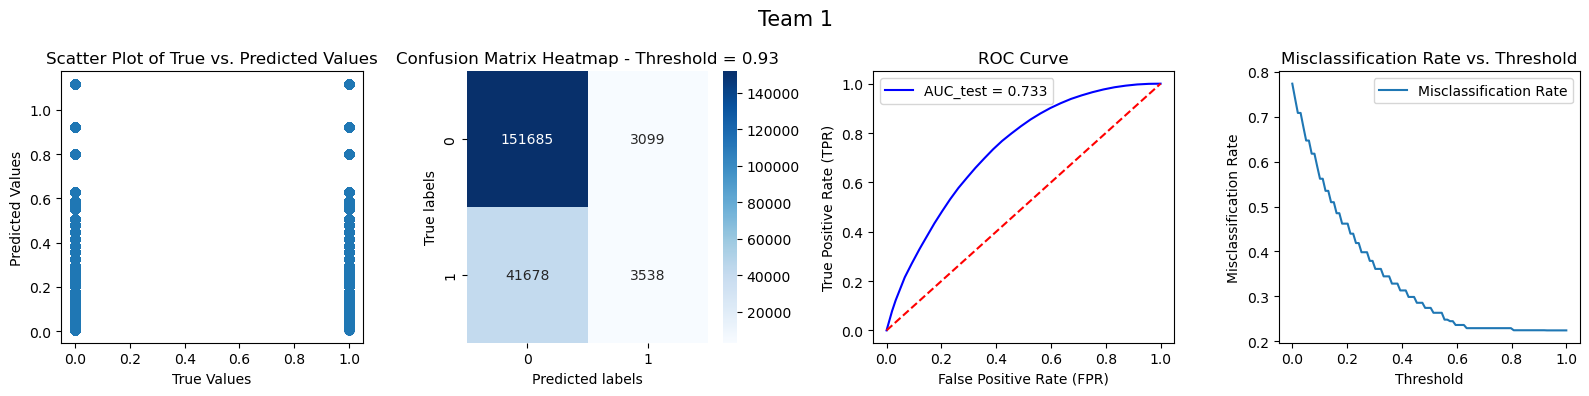

In [18]:
plot_func(df_all.default, df_all.BEIR_1,name='Team 1')

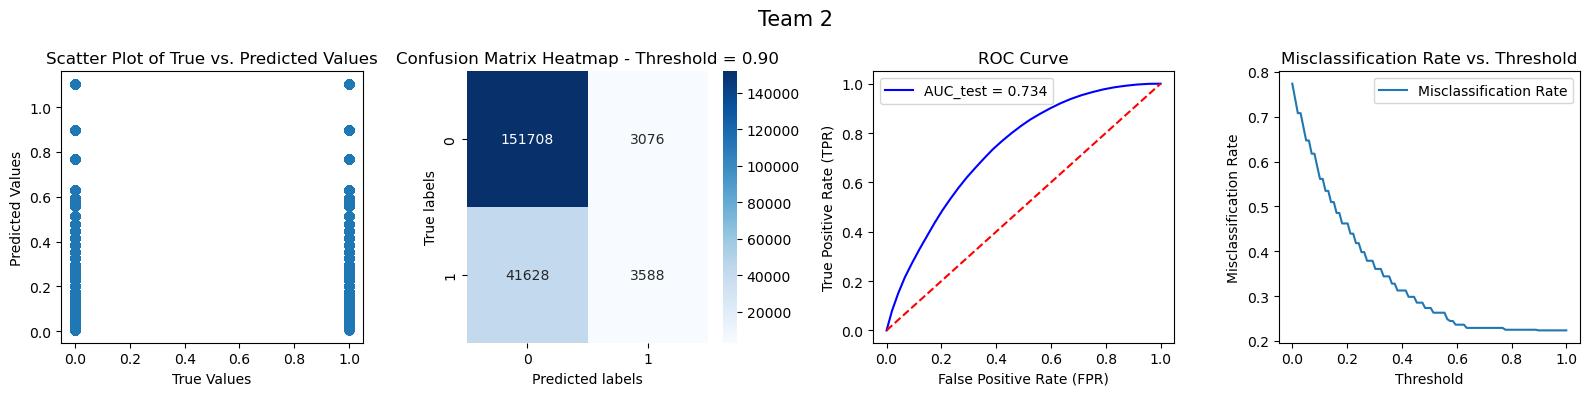

In [19]:
plot_func(df_all.default, df_all.BEIR_2,name='Team 2')

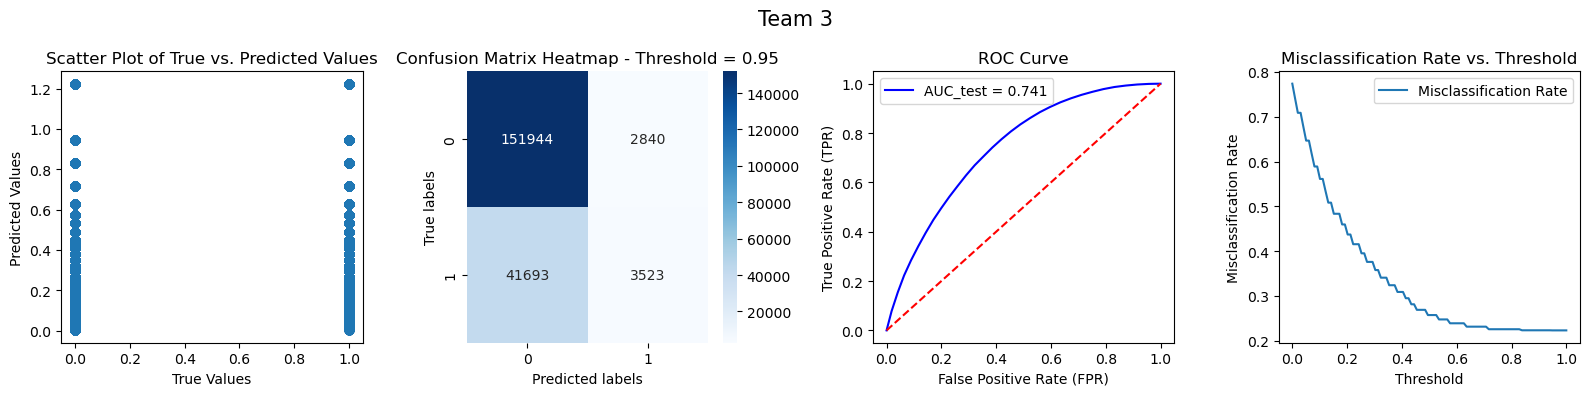

In [20]:
plot_func(df_all.default, df_all.BEIR_3,name='Team 3')

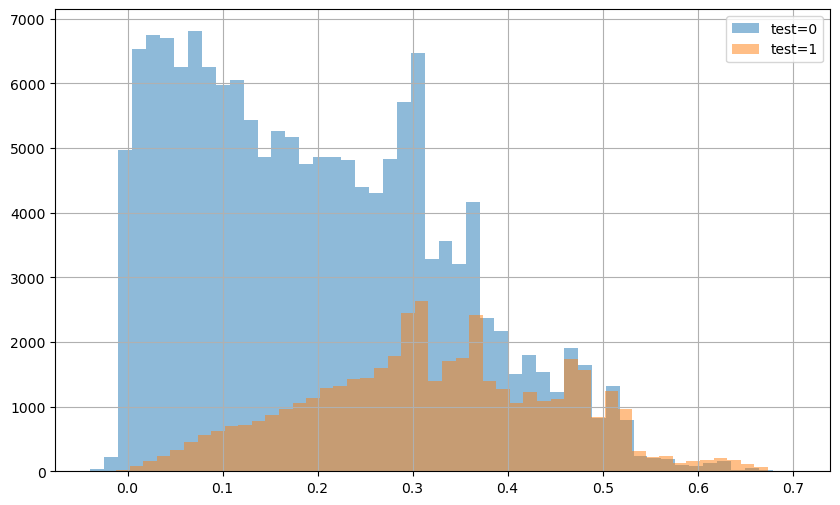

In [21]:
df_ = pd.DataFrame()
df_['pred'] = df_all.pred_team3.to_numpy()
df_['test'] = df_all.default.to_numpy()

# Create a plot
fig, ax = plt.subplots(figsize=(10, 6))

# Group by 'test' and plot histograms
for key, group in df_.groupby(by='test'):
    group.pred.hist(ax=ax, bins=50, alpha=0.5, label=f"test={key}")

# Adding legend to differentiate between groups
ax.legend()

plt.show()

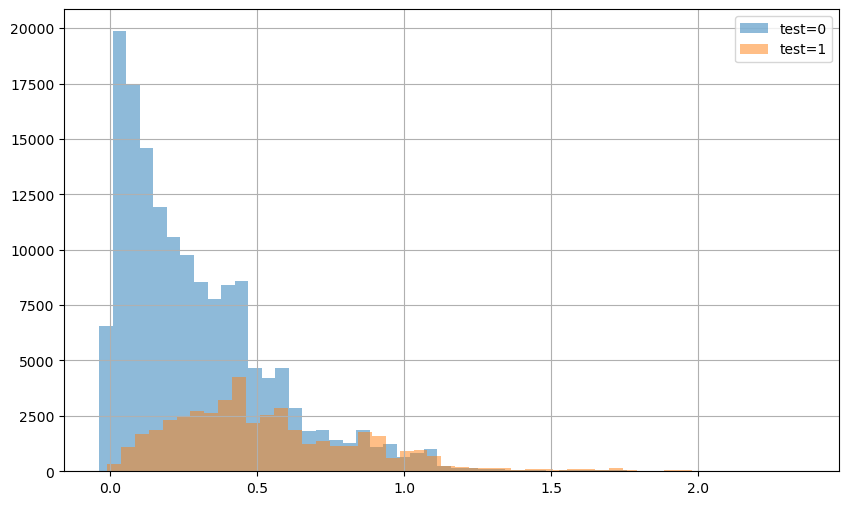

In [22]:
df_ = pd.DataFrame()
df_['pred'] = df_all.pred_team3.to_numpy() / (1 - df_all.pred_team3.to_numpy())
df_['test'] = df_all.default.to_numpy()

# Create a plot
fig, ax = plt.subplots(figsize=(10, 6))

# Group by 'test' and plot histograms
for key, group in df_.groupby(by='test'):
    group.pred.hist(ax=ax, bins=50, alpha=0.5, label=f"test={key}")

# Adding legend to differentiate between groups
ax.legend()

plt.show()

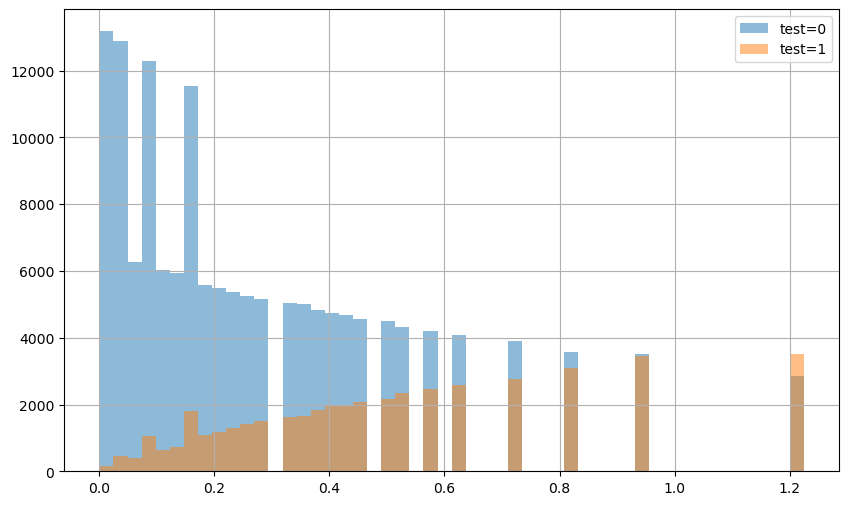

In [23]:
df_ = pd.DataFrame()
df_['pred'] = df_all.BEIR_3.to_numpy()
df_['test'] = df_all.default.to_numpy()

# Create a plot
fig, ax = plt.subplots(figsize=(10, 6))

# Group by 'test' and plot histograms
for key, group in df_.groupby(by='test'):
    group.pred.hist(ax=ax, bins=50, alpha=0.5, label=f"test={key}")

# Adding legend to differentiate between groups
ax.legend()

plt.show()

### Binned premium

In [24]:
def partition_dataframe(df, bins):
    # Partition the 'rate' column into 10 quantiles
    df['quantile'] = pd.qcut(df['tot_rate_3'], bins, labels=False, duplicates='drop')
    
    # Group by the quantiles and convert to dictionary
    result = {key: group.drop(columns='quantile') for key, group in df.groupby('quantile')}
    
    return result

In [25]:
def conpute_best_rate(df, plot=True):
    premium_list = np.arange(-10,70,.1)
    gain_team_1_list = []
    gain_team_2_list = []
    gain_team_3_list = []
    for premium in premium_list:
        df_all = add_premium(df,[0,0,premium])
        gain_list = gain_compute(df_all)
        gain_team_1_list.append(gain_list[0])
        gain_team_2_list.append(gain_list[1])
        gain_team_3_list.append(gain_list[2])
    if plot:
        fig, ax = plt.subplots(figsize=(10,6))
        ax.plot(premium_list, gain_team_1_list,label=('team_1'))
        ax.plot(premium_list, gain_team_2_list,label=('team_2'))
        ax.plot(premium_list, gain_team_3_list,label=('team_3'))
        ax.legend()
        ax.set_xlabel('Premium rate')
        ax.set_ylabel('Gain')
        plt.grid()
    return(premium_list[np.argmax(gain_team_3_list)] )

In [26]:
bins= 28
best_premium_list = [conpute_best_rate(partition_dataframe(df_all, bins=bins)[i], plot=False) for i in tqdm(list(partition_dataframe(df_all, bins=bins).keys()))]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 28/28 [01:45<00:00,  3.76s/it]


In [27]:
best_premium_list

[2.1999999999999567,
 2.099999999999957,
 2.099999999999957,
 2.1999999999999567,
 3.9999999999999503,
 3.8999999999999506,
 2.1999999999999567,
 4.399999999999949,
 4.699999999999948,
 4.999999999999947,
 8.099999999999937,
 8.699999999999932,
 9.09999999999993,
 7.699999999999939,
 13.599999999999916,
 11.699999999999925,
 14.799999999999912,
 12.89999999999992,
 10.199999999999928,
 11.699999999999925,
 11.799999999999923,
 25.499999999999872,
 19.499999999999893,
 37.09999999999983,
 20.099999999999895,
 16.899999999999906,
 5.399999999999945,
 -10.0]

In [28]:
len(best_premium_list)

28

In [29]:
dict_df = partition_dataframe(df_all, bins=bins)
for i in list(dict_df.keys()):
    dict_df[i] = dict_df[i].assign(tot_rate_3 = lambda x : x.tot_rate_3 + best_premium_list[i]/100)
all_df = pd.concat(list(dict_df.values()))

In [30]:
all_df

,default,pred_team1,BEIR_1,pred_team2,BEIR_2,pred_team3,BEIR_3,prefered_lender,tot_rate_1,tot_rate_2,tot_rate_3
1,0,0.013507,0.018444,0.029277,0.032121,0.014686,0.016091,1,0.038444,0.052121,0.038091
10,0,-0.012340,0.003257,-0.010604,0.003226,0.017789,0.016091,3,0.023257,0.023226,0.038091
12,0,0.001607,0.003257,0.032550,0.032121,0.006719,0.000762,2,0.023257,0.052121,0.022762
23,0,0.004581,0.003257,-0.003414,0.003226,0.011083,0.016091,3,0.023257,0.023226,0.038091
27,0,0.025667,0.032834,0.031973,0.032121,0.017838,0.016091,1,0.052834,0.052121,0.038091
...,...,...,...,...,...,...,...,...,...,...,...
199850,0,0.651528,1.117979,0.445127,0.770307,0.540624,1.224368,3,1.137979,0.790307,1.124368
199867,0,0.480768,0.921372,0.478668,0.898285,0.536151,1.224368,1,0.941372,0.918285,1.124368
199906,1,0.480768,0.921372,0.478668,0.898285,0.555694,1.224368,2,0.941372,0.918285,1.124368
199923,0,0.475465,0.921372,0.466918,0.770307,0.516958,1.224368,2,0.941372,0.790307,1.124368


In [31]:
print(all_df.pred_team3.nunique())
print(all_df.BEIR_3.nunique())
print(all_df.tot_rate_3.nunique())

97716
30
30


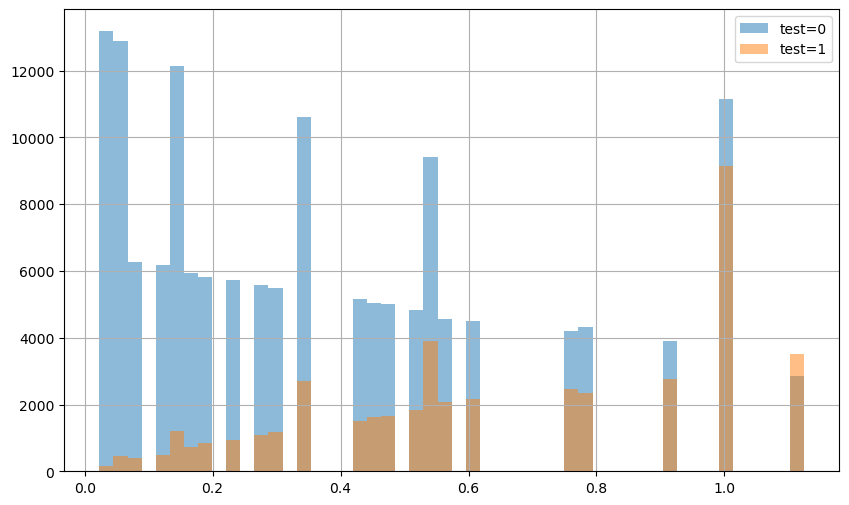

In [32]:
df_ = pd.DataFrame()
df_['pred'] = all_df.tot_rate_3.to_numpy()
df_['test'] = all_df.default.to_numpy()

# Create a plot
fig, ax = plt.subplots(figsize=(10, 6))

# Group by 'test' and plot histograms
for key, group in df_.groupby(by='test'):
    group.pred.hist(ax=ax, bins=50, alpha=0.5, label=f"test={key}")

# Adding legend to differentiate between groups
ax.legend()

plt.show()

### Try with real data

In [33]:
binned_premium_real = np.array(
[-0.4000000000000341,
 -1.300000000000031,
 0.4999999999999627,
 3.6999999999999513,
 0.2999999999999634,
 7.29999999999994,
 1.1999999999999602,
 8.799999999999933,
 19.999999999999893,
 5.299999999999946,
 14.799999999999912,
 51.39999999999978,
 17.099999999999902,
 49.19999999999979,
 59.999999999999744,
 28.599999999999866,
 57.99999999999976,
 49.99999999999979,
 55.99999999999977,
 53.39999999999978,
 50.399999999999785,
 43.89999999999981,
 42.59999999999981,
 38.49999999999983,
 33.19999999999985,
 24.49999999999988,
 10.899999999999928,
 -10.0]
) - 3.9

In [34]:
print(len(best_premium_list))
print(len(binned_premium_real))

28
28


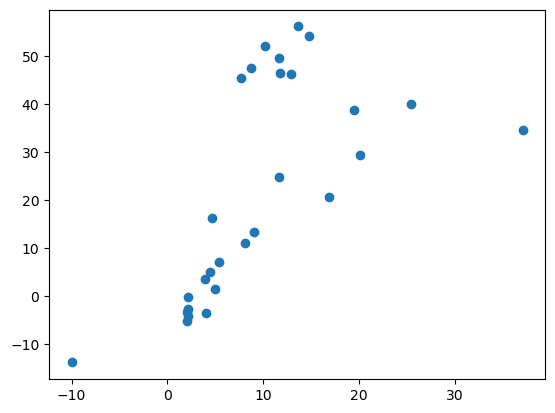

In [35]:
plt.scatter(best_premium_list, binned_premium_real)

## Submission

In [36]:
df_new = pd.read_csv('LendingGame_Lender3/31/NewApplications_Lender3_Round2.csv')

In [37]:
df_new.sample(10)

,id,sex,employment,married,income,digital3
63544,163545,0,retired,1,2843,0.000000
46915,146916,1,retired,0,14051,0.000000
54222,154223,1,employed,1,7693,0.219919
78607,178608,0,retired,1,5639,0.119778
41351,141352,0,student,0,2594,0.060814
63346,163347,0,employed,1,20922,0.687417
63819,163820,1,employed,1,80298,0.413729
47420,147421,1,employed,1,7123,0.462857
86566,186567,0,retired,0,5545,0.033327
81001,181002,0,employed,1,4724,0.821819


In [38]:
df_new.income = df_new.income.astype('int32')
df_new.digital3 = df_new.digital3.astype('float32')
df_new.employment = df_new.employment.astype('category')
df_new.sex = df_new.sex.astype('category')
df_new.married = df_new.married.astype('category')

In [39]:
def get_pred_final(params, data_old, data_new):


    X_train, X_test, y_train, y_test = train_test_split(data_old.drop(columns=['default','digital1','digital2']),
                                                        data_old['default'],
                                                        test_size=1,
                                                        random_state=42)
    y_train_ = y_train[X_train.income < 140_000]
    X_train_ = X_train[X_train.income < 140_000]


    best_hyperparameters = params.copy()
    best_hyperparameters['bootstrap_type'] = ["Bayesian", "Bernoulli", "MVS", "No"][params['bootstrap_type']]
    best_hyperparameters['grow_policy'] = ["SymmetricTree", "Depthwise", "Lossguide"][params['grow_policy']]
    best_hyperparameters['depth'] = int(params['depth'])

    # Add categorical features
    cat_features = X_train.select_dtypes(['category']).columns.tolist()
    best_hyperparameters['cat_features'] = ['married','sex','employment']

    # Initialize the regressor
    regressor = CatBoostRegressor(**best_hyperparameters, logging_level='Silent') 

    regressor.fit(X_train_,y_train_)

    #y_pred = regressor.predict(X_test)
    #y_pred[X_test.income >= 140_000] = 0
    y_pred = regressor.predict(data_new.drop(columns=['id']))
    y_pred[data_new.income >= 140_000] = 0
    data_new['PD'] = y_pred
    return(data_new)

In [40]:
df_new_1 = get_pred_final(params_3, df_past, df_new)

In [41]:
df_new_1['bins'] = pd.qcut(df_new_1.PD, 30)
df_new_1['BEIR'] = ([df_new_1[df_new_1['bins'] == x].PD.mean() 
                                            / (1 - df_new_1[df_new_1['bins'] == x].PD.mean() )
                                            for x in tqdm(df_new_1['bins'].to_numpy())])

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [00:57<00:00, 1727.47it/s]


In [42]:
df_new_1

,id,sex,employment,married,income,digital3,PD,bins,BEIR
0,100001,1,employed,1,21002,0.150382,0.148943,"(0.138, 0.154]",0.171205
1,100002,1,employed,1,53578,0.522883,0.025675,"(0.0221, 0.0361]",0.029862
2,100003,1,employed,0,38230,0.795641,0.052612,"(0.0513, 0.065]",0.061806
3,100004,0,retired,0,15689,0.153950,0.106831,"(0.106, 0.121]",0.128167
4,100005,1,unemployed,1,6770,0.799177,0.239965,"(0.235, 0.252]",0.321898
...,...,...,...,...,...,...,...,...,...
99995,199996,1,student,1,0,0.976321,0.269258,"(0.269, 0.281]",0.378249
99996,199997,1,unemployed,1,0,0.729714,0.411096,"(0.398, 0.428]",0.702267
99997,199998,1,unemployed,1,0,0.448791,0.474040,"(0.472, 0.508]",0.958107
99998,199999,0,student,1,0,0.593692,0.365511,"(0.356, 0.371]",0.571118


In [43]:
bins = 30
mean_list = [partition_dataframe(df_all, bins=bins)[i].BEIR_3.mean() for i in list(partition_dataframe(df_all, bins=bins).keys())]
binned_premium_list = [conpute_best_rate(partition_dataframe(df_all, bins=bins)[i], plot=False) for i in tqdm(list(partition_dataframe(df_all, bins=bins).keys()))]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [01:51<00:00,  3.70s/it]


In [44]:
mean_list

[0.0007620581739929013,
 0.016090587840226492,
 0.030669122633529337,
 0.04574916648593701,
 0.06161217719197413,
 0.07781670954227034,
 0.09417147910358567,
 0.111202932855253,
 0.12947863573915572,
 0.149563514019796,
 0.17176402881215075,
 0.19468555280848526,
 0.21753536268904836,
 0.24246049641176098,
 0.2673747781082038,
 0.29322744328581984,
 0.3202790091862847,
 0.3494257322954137,
 0.3790370352993922,
 0.40740376509784,
 0.4300450484908203,
 0.45148962938935505,
 0.4907903354236147,
 0.534458274336436,
 0.5752722650997341,
 0.6283641949241512,
 0.7165331774767025,
 0.8314127212779524,
 0.9463169351238248,
 1.2243679706557704]

In [45]:
binned_premium_list

[2.1999999999999567,
 2.1999999999999567,
 2.099999999999957,
 2.099999999999957,
 2.1999999999999567,
 3.9999999999999503,
 3.8999999999999506,
 2.1999999999999567,
 4.399999999999949,
 4.699999999999948,
 4.999999999999947,
 8.099999999999937,
 8.699999999999932,
 9.09999999999993,
 7.699999999999939,
 13.299999999999919,
 7.5999999999999375,
 11.699999999999925,
 14.799999999999912,
 12.89999999999992,
 10.199999999999928,
 11.699999999999925,
 11.799999999999923,
 25.499999999999872,
 19.499999999999893,
 37.09999999999983,
 20.099999999999895,
 16.899999999999906,
 5.399999999999945,
 -10.0]

In [46]:
# Function to find the index of the nearest value in mean_list
def find_nearest_idx(value):
    return min(range(len(mean_list)), key=lambda i: abs(mean_list[i] - value))

# Get the index of the nearest value in mean_list for each row in 'BEIR' column
nearest_idx = df_new_1['BEIR'].apply(find_nearest_idx)

# Map values from binned_premium_list using the obtained index
mapped_values = nearest_idx.map(lambda x: binned_premium_list[x])

# Create a new column by adding the mapped values to the 'BEIR' column
df_new_1['BEIR_premium'] = df_new_1['BEIR'] + mapped_values/100

In [47]:
df_new_1

,id,sex,employment,married,income,digital3,PD,bins,BEIR,BEIR_premium
0,100001,1,employed,1,21002,0.150382,0.148943,"(0.138, 0.154]",0.171205,0.221205
1,100002,1,employed,1,53578,0.522883,0.025675,"(0.0221, 0.0361]",0.029862,0.050862
2,100003,1,employed,0,38230,0.795641,0.052612,"(0.0513, 0.065]",0.061806,0.083806
3,100004,0,retired,0,15689,0.153950,0.106831,"(0.106, 0.121]",0.128167,0.172167
4,100005,1,unemployed,1,6770,0.799177,0.239965,"(0.235, 0.252]",0.321898,0.397898
...,...,...,...,...,...,...,...,...,...,...
99995,199996,1,student,1,0,0.976321,0.269258,"(0.269, 0.281]",0.378249,0.526249
99996,199997,1,unemployed,1,0,0.729714,0.411096,"(0.398, 0.428]",0.702267,0.903267
99997,199998,1,unemployed,1,0,0.448791,0.474040,"(0.472, 0.508]",0.958107,1.012107
99998,199999,0,student,1,0,0.593692,0.365511,"(0.356, 0.371]",0.571118,0.766118


In [49]:
df_final = df_new_1[['id','BEIR_premium']].copy()
df_final.loc[df_final.BEIR_premium > 1, 'BEIR_premium'] = np.nan

In [50]:
df_final

,id,BEIR_premium
0,100001,0.221205
1,100002,0.050862
2,100003,0.083806
3,100004,0.172167
4,100005,0.397898
...,...,...
99995,199996,0.526249
99996,199997,0.903267
99997,199998,NaN
99998,199999,0.766118


In [53]:
df_final[df_final.BEIR_premium.isna()].id

21       100022
29       100030
37       100038
47       100048
72       100073
          ...  
99964    199965
99967    199968
99973    199974
99988    199989
99997    199998
Name: id, Length: 9995, dtype: int64

In [63]:
df_plot = df_new_1.copy()
df_plot['is_client'] = ~df_final.BEIR_premium.isna()
df_plot

,id,sex,employment,married,income,digital3,PD,bins,BEIR,BEIR_premium,is_client
0,100001,1,employed,1,21002,0.150382,0.148943,"(0.138, 0.154]",0.171205,0.221205,True
1,100002,1,employed,1,53578,0.522883,0.025675,"(0.0221, 0.0361]",0.029862,0.050862,True
2,100003,1,employed,0,38230,0.795641,0.052612,"(0.0513, 0.065]",0.061806,0.083806,True
3,100004,0,retired,0,15689,0.153950,0.106831,"(0.106, 0.121]",0.128167,0.172167,True
4,100005,1,unemployed,1,6770,0.799177,0.239965,"(0.235, 0.252]",0.321898,0.397898,True
...,...,...,...,...,...,...,...,...,...,...,...
99995,199996,1,student,1,0,0.976321,0.269258,"(0.269, 0.281]",0.378249,0.526249,True
99996,199997,1,unemployed,1,0,0.729714,0.411096,"(0.398, 0.428]",0.702267,0.903267,True
99997,199998,1,unemployed,1,0,0.448791,0.474040,"(0.472, 0.508]",0.958107,1.012107,False
99998,199999,0,student,1,0,0.593692,0.365511,"(0.356, 0.371]",0.571118,0.766118,True


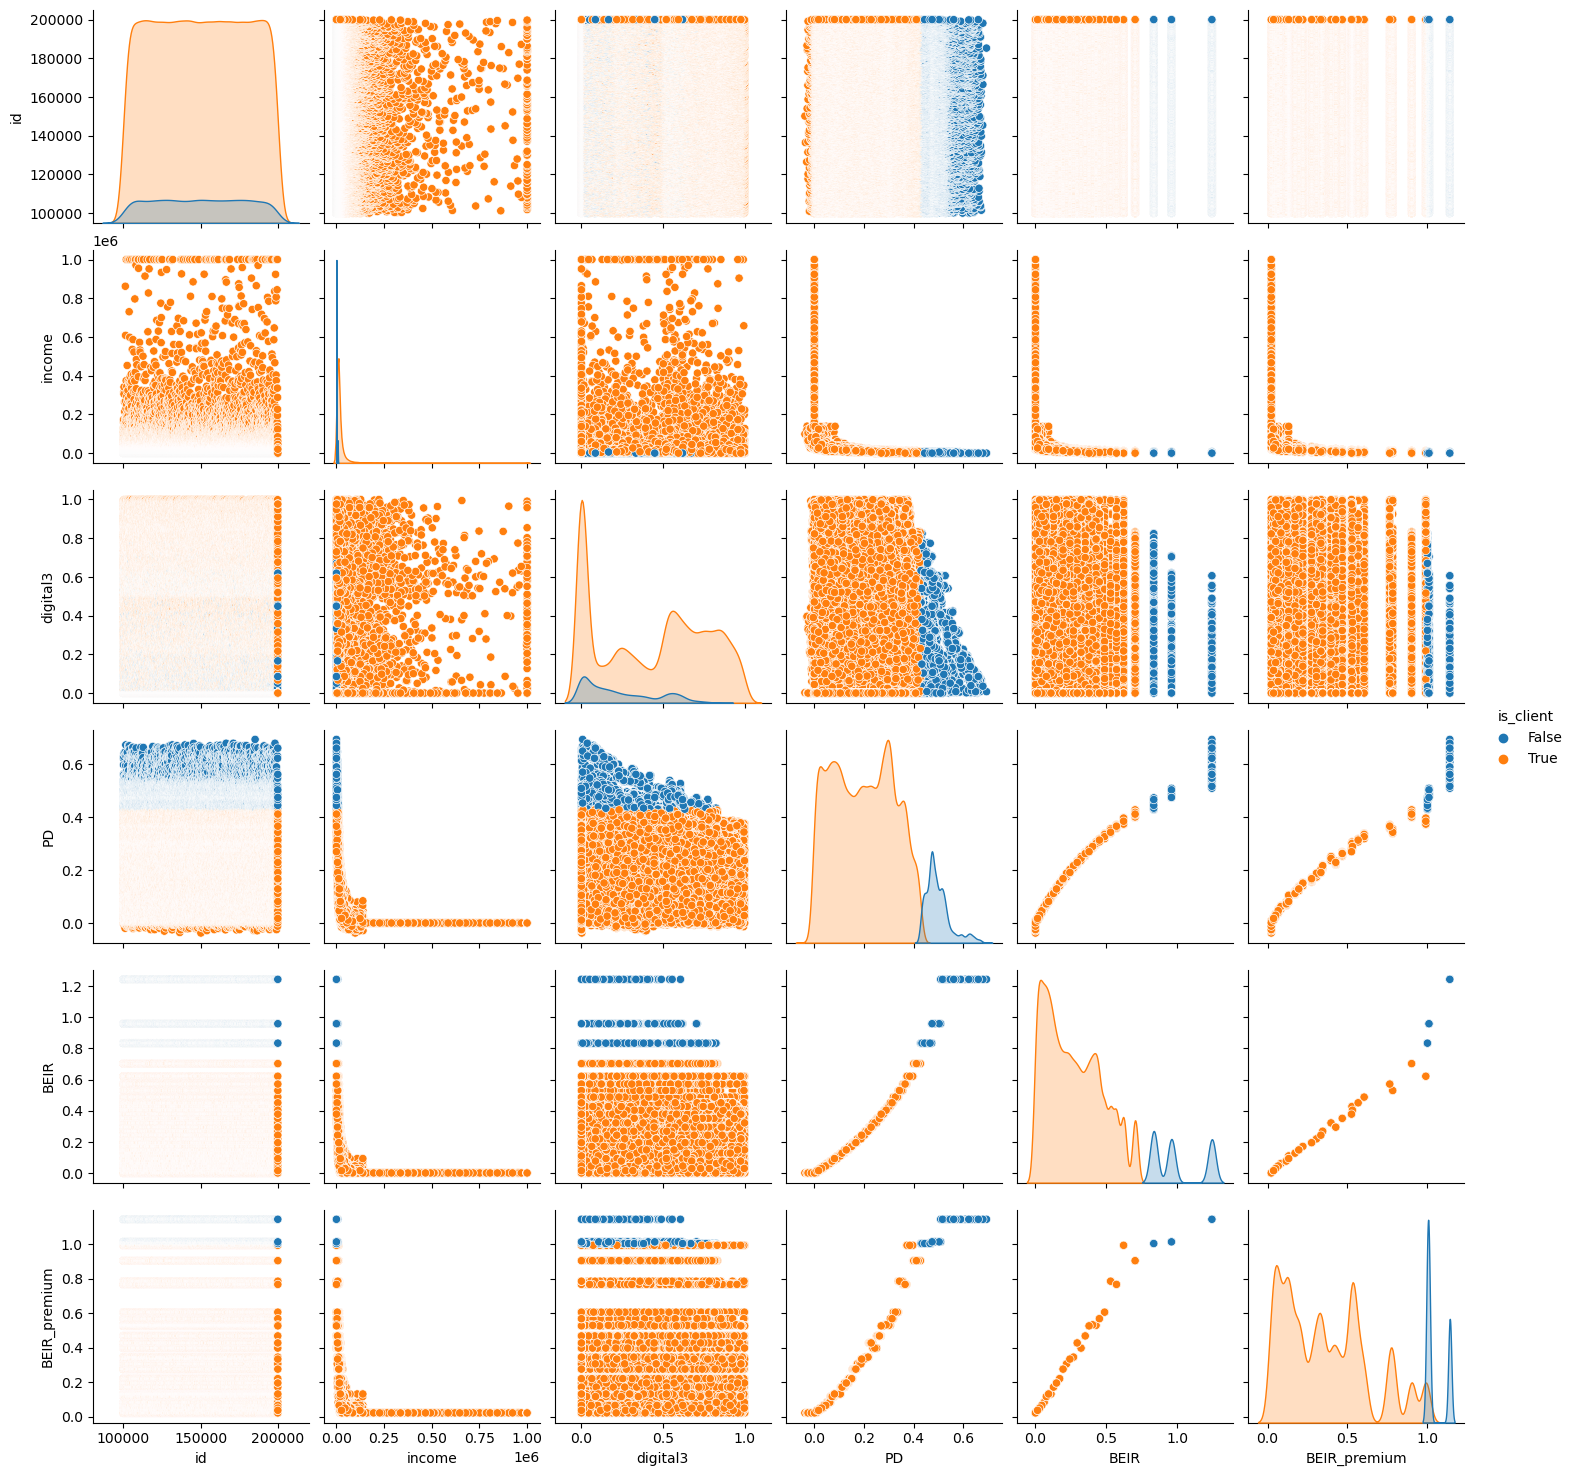

In [64]:
sns.pairplot(df_plot, hue="is_client")

In [65]:
df_final.to_csv('submission_group_3_round_2.csv', index=False)

In [66]:
df_final.describe()

,id,BEIR_premium
count,100000.000000,90005.000000
mean,150000.500000,0.370254
std,28867.657797,0.270360
min,100001.000000,0.023024
25%,125000.750000,0.132310
50%,150000.500000,0.334326
75%,175000.250000,0.532325
max,200000.000000,0.992245
